# ChEMBL molecules details

Get more details on molecules from the recombined library that were found in ChEMBL:
- Get targets that these molecules are active on
- Get classification for these targets (e.g. are these targets kinases?)

In [113]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import requests
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = -1

## Load recombinded molecules deposited in ChEMBL

These are the molecules from the recombined library that were found in ChEMBL.

In [3]:
with open('novel_chembl_mols.txt', 'r') as f:
    lines = f.readlines()
    
molecules = [i[:-1] for i in lines]
molecules = [Chem.InchiToInchiKey(inchi) for inchi in molecules]

In [4]:
len(molecules)

121

In [5]:
# Example molecules (in the form of InCHI keys)
molecules[:2]

['PBCBIZJDVCDFNU-JTQLQIEISA-N', 'XOJAJRFBOKCXPI-UHFFFAOYSA-N']

## Get ChEMBL clients

In [6]:
similarity = new_client.similarity
compound = new_client.molecule
activity = new_client.activity
target = new_client.target

## Get molecule ChEMBL IDs

In [7]:
details = []

for molecule in molecules:
    
    result = compound.get(molecule) # similarity.filter(smiles=molecule, similarity=100)
    
    details.append(
        {
            'smiles': result['molecule_structures']['canonical_smiles'], 
            'inchi': result['molecule_structures']['standard_inchi'],
            'atc_classification': result['atc_classifications'], 
            'first_approval': result['first_approval'],
            'chembl_id': result['molecule_chembl_id']
        }
    )
        
details = pd.DataFrame(details)

In [8]:
print(f'Number of queries: {len(molecules)}')
print(f'Number of query results: {details.shape[0]}')

Number of queries: 121
Number of query results: 121


In [9]:
details.head()

,atc_classification,chembl_id,first_approval,inchi,smiles
0,[],CHEMBL520734,None,"InChI=1S/C15H18N4O2S2/c16-15(21)19-14-11(6-12(23-14)9-3-5-22-8-9)13(20)18-10-2-1-4-17-7-10/h3,5-6,8,10,17H,1-2,4,7H2,(H,18,20)(H3,16,19,21)/t10-/m0/s1",NC(=O)Nc1sc(cc1C(=O)N[C@H]2CCCNC2)c3ccsc3
1,[],CHEMBL2064599,None,"InChI=1S/C14H13NO2/c1-17-13-9-7-11(8-10-13)14(16)15-12-5-3-2-4-6-12/h2-10H,1H3,(H,15,16)",COc1ccc(cc1)C(=O)Nc2ccccc2
2,[],CHEMBL1562513,None,"InChI=1S/C13H17NO/c15-13(11-7-3-1-4-8-11)14-12-9-5-2-6-10-12/h2,5-6,9-11H,1,3-4,7-8H2,(H,14,15)",O=C(Nc1ccccc1)C2CCCCC2
3,[],CHEMBL487776,None,"InChI=1S/C18H21N5/c1-13-16-12-19-18(21-15-10-6-3-7-11-15)22-23(16)17(20-13)14-8-4-2-5-9-14/h2,4-5,8-9,12,15H,3,6-7,10-11H2,1H3,(H,21,22)",Cc1nc(c2ccccc2)n3nc(NC4CCCCC4)ncc13
4,[],CHEMBL1446166,None,"InChI=1S/C16H11ClN2OS/c17-12-6-8-13(9-7-12)18-15(20)14-10-21-16(19-14)11-4-2-1-3-5-11/h1-10H,(H,18,20)",Clc1ccc(NC(=O)c2csc(n2)c3ccccc3)cc1


## Keep track of filtering

In [10]:
filtering = pd.DataFrame(
    columns=[
        'filtering_step',
        'molecules',
        'targets',
        'assays',
        'values'
    ]
)
filtering

,filtering_step,molecules,targets,assays,values


In [11]:
def add_filtering_step(filtering, df, step_name):
    
    return filtering.append(
        pd.Series(
            [
                step_name,
                len(df.molecule_chembl_id.unique()),
                len(df.target_chembl_id.unique()),
                len(df.assay_chembl_id.unique()),
                df.shape[0]
            ],
            index=['filtering_step', 'molecules', 'targets', 'assays', 'values']
        ),
        ignore_index=True
    )

## Get measured bioactivities for molecules

In [12]:
activities = activity.filter(
    molecule_chembl_id__in = list(details.chembl_id),
    type = 'IC50', 
    relation = '=', 
    assay_type = 'B'
).only(
    'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
    'molecule_chembl_id', 'type', 'units', 'relation', 'value', \
    'target_chembl_id', 'target_organism', 'target_pref_name'
)

In [13]:
len(activities)

69

In [14]:
bioact_df = pd.DataFrame.from_records(list(activities))
bioact_df.shape

(69, 12)

In [15]:
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,target_pref_name,type,units,value
0,314877,CHEMBL751094,In vitro inhibitory activity against H1N9 strain of Influenza Neuraminidase (membrane),B,CHEMBL414,=,CHEMBL3046,Homo sapiens,Sialidase 3,IC50,mM,2.5
1,388701,CHEMBL615559,In vitro inhibition against of 4-Hydroxyphenylpyruvate dioxygenase (4-HPPD) from pig liver by the enol borate method,B,CHEMBL297343,=,CHEMBL3203,Sus scrofa,4-hydroxyphenylpyruvate dioxygenase,IC50,uM,6
2,477909,CHEMBL661123,Evaluated for inhibition of human cyclin dependent kinase 2,B,CHEMBL269827,=,CHEMBL301,Homo sapiens,Cyclin-dependent kinase 2,IC50,nM,2.3
3,479851,CHEMBL658939,In vitro inhibition of Cyclin-dependent kinase 2,B,CHEMBL311992,=,CHEMBL301,Homo sapiens,Cyclin-dependent kinase 2,IC50,nM,12
4,1021445,CHEMBL732386,Inhibitory concentration against rat brain mitochondrial monoamine oxidase A,B,CHEMBL300999,=,CHEMBL3358,Rattus norvegicus,Monoamine oxidase A,IC50,uM,0.002


In [16]:
filtering = add_filtering_step(filtering, bioact_df, 'ChEMBL bioactivity entries')
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69


### Remove bioactivities for non-human target organisms

In [17]:
bioact_df = bioact_df[bioact_df.target_organism == 'Homo sapiens']
bioact_df.shape

(48, 12)

In [18]:
filtering = add_filtering_step(filtering, bioact_df, 'Only human entries')
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69
1,Only human entries,24,33,46,48


### Convert units to nM

In [19]:
bioact_df.units.unique()

array(['mM', 'nM', 'uM'], dtype=object)

In [20]:
def convert_to_nM(unit, bioactivity):
    
    conversion_factors = {
        "pM": 1e-3,
        "10'-11M": 1e-2,
        "10'-10M": 1e-1,
        "nM": 1e+0,
        "10'-8M": 1e+1,
        "10'-1microM": 1e+2,
        "10'-7M": 1e+2,
        "uM": 1e+3,
        "/uM": 1e+3,
        "10'-6M": 1e+3,
        "10'1 uM": 1e+4,
        "10'2 uM": 1e+5,
        "mM": 1e+6,
        "mmol/L": 1e+6,
        "M": 1e+9
    }
    
    try:
        return float(bioactivity) * conversion_factors[unit]
        
    except KeyError:
        print(f'Unit not recognized: {unit}')
        return

In [21]:
bioact_df.rename(columns={"units": "units_original", "value": "value_original"}, inplace=True)

In [22]:
# Convert values to nM
bioactivity_nM = []

for i, row in bioact_df.iterrows():
    bioactivity_nM.append(
        convert_to_nM(row['units_original'], row['value_original'])
    )
    
bioact_df['value'] = bioactivity_nM
bioact_df['units'] = 'nM'
bioact_df.shape

(48, 14)

In [23]:
bioact_df.value.plot(kind='hist')

In [24]:
bioact_df = bioact_df.astype({'value': 'float'})

### Get tested targets (and assay types) per molecule

In [25]:
bioact_df[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id']
].groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name']
).count()

assay_chembl_id
molecule_chembl_id target_chembl_id target_pref_name                                                      
CHEMBL124267       CHEMBL2424504    Lysine-specific demethylase 5A                         1              
CHEMBL1410991      CHEMBL5393       ATP-binding cassette sub-family G member 2             1              
CHEMBL1709874      CHEMBL3708265    7,8-dihydro-8-oxoguanine triphosphatase                1              
CHEMBL1830693      CHEMBL240        HERG                                                   1              
CHEMBL2030386      CHEMBL2147       Serine/threonine-protein kinase PIM1                   2              
                   CHEMBL3038477    Casein kinase II alpha/beta                            1              
                   CHEMBL3883328    Casein kinase II alpha'/ beta                          1              
                   CHEMBL4523       Serine/threonine-protein kinase PIM2                   1              
                   CHEMBL5407       Serine/threonine-protein kinase PIM3                   1              
                   CHEMBL5443       Cell division cycle 7-related protein kinase           2              
CHEMBL2152572      CHEMBL4506       NAD-dependent deacetylase sirtuin 1                    1              
CHEMBL2152576      CHEMBL4462       NAD-dependent deacetylase sirtuin 2                    1              
CHEMBL2430324      CHEMBL260        MAP kinase p38 alpha                                   1              
CHEMBL269827       CHEMBL301        Cyclin-dependent kinase 2                              3              
                   CHEMBL3038467    CDK1/Cyclin A                                          1              
                   CHEMBL3038469    CDK2/Cyclin A                                          1              
                   CHEMBL308        Cyclin-dependent kinase 1                              2              
CHEMBL271967       CHEMBL5147       Ephrin type-B receptor 4                               5              
CHEMBL311992       CHEMBL301        Cyclin-dependent kinase 2                              1              
CHEMBL3326132      CHEMBL1075104    Leucine-rich repeat serine/threonine-protein kinase 2  2              
CHEMBL3342907      CHEMBL2276       c-Jun N-terminal kinase 1                              1              
CHEMBL3661365      CHEMBL1968       Epoxide hydrolase 1                                    1              
CHEMBL3680991      CHEMBL5247       Serine/threonine-protein kinase ILK-1                  2              
CHEMBL3911800      CHEMBL1795168    CDGSH iron-sulfur domain-containing protein 1          1              
CHEMBL4068426      CHEMBL2842       Serine/threonine-protein kinase mTOR                   1              
CHEMBL414          CHEMBL205        Carbonic anhydrase II                                  1              
                   CHEMBL3046       Sialidase 3                                            1              
                   CHEMBL4789       Carbonic anhydrase VA                                  1              
CHEMBL451155       CHEMBL3629       Casein kinase II alpha                                 1              
                   CHEMBL3832943    Casein kinase 2                                        1              
CHEMBL470288       CHEMBL4630       Serine/threonine-protein kinase Chk1                   1              
                   CHEMBL5578       Cyclin-dependent kinase 2-associated protein 1         1              
CHEMBL486551       CHEMBL3024       Serine/threonine-protein kinase PLK1                   1              
CHEMBL520734       CHEMBL4630       Serine/threonine-protein kinase Chk1                   1              
                   CHEMBL5578       Cyclin-dependent kinase 2-associated protein 1         1              
CHEMBL526133       CHEMBL5443       Cell division cycle 7-related protein kinase           1              
CHEMBL54922        CHEMBL

### Get molecules that are "active" (<=500 nM) against at least one target

In [26]:
activity_threshold = 500

In [27]:
# Group bioactivity results by molecule ChEMBL ID
bioact_df_grouped = bioact_df[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'value']
].groupby(
    ['molecule_chembl_id']
)

In [28]:
# Which molecules are "active" against at least one target
bioact_df_active = bioact_df_grouped.apply(
    lambda x: x if (sum(x.value <= activity_threshold) > 0) else None
).dropna()

In [29]:
bioact_df_active.sort_values(by='molecule_chembl_id', inplace=True)

In [30]:
bioact_df_active.shape

(27, 6)

In [31]:
filtering = add_filtering_step(filtering, bioact_df_active, 'Only "active" entries')
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69
1,Only human entries,24,33,46,48
2,"Only ""active"" entries",11,17,25,27


In [32]:
bioact_df_active[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'value']
].groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'value']
).count()

Empty DataFrame
Columns: []
Index: [(CHEMBL1410991, CHEMBL5393, ATP-binding cassette sub-family G member 2, CHEMBL4015695, Inhibition of recombinant human GFP-fused ABCG2 expressed in MDCK2 cells assessed as reduction in Hoechst 33342 efflux preincubated for 30 mins followed by Hoechst 33342 addition measured immediately at 60 sec time interval for 120 mins by fluorescence assay, 211.0), (CHEMBL1709874, CHEMBL3708265, 7,8-dihydro-8-oxoguanine triphosphatase, CHEMBL3877226, Inhibition of DsRed-fused MTH1 (unknown origin) expressed in HEK293T cells using 8-oxo-dGTP as substrate, 100.0), (CHEMBL2030386, CHEMBL2147, Serine/threonine-protein kinase PIM1, CHEMBL2034662, Inhibition of N-terminus His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by chemiluminescence assay, 13.0), (CHEMBL2030386, CHEMBL2147, Serine/threonine-protein kinase PIM1, CHEMBL2038008, Inhibition of N-terminal His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay, 5.0), (CHEMBL2030386, CHEMBL3038477, Casein kinase II alpha/beta, CHEMBL2034661, Inhibition of human tertrameric CK2alphabeta holoenzyme using casein as substrate after 1 to 2 hrs by chemiluminescence assay in presence of 2 uM ATP, 89.0), (CHEMBL2030386, CHEMBL3883328, Casein kinase II alpha'/ beta, CHEMBL2038011, Inhibition of N-terminal MBP-tagged human alpha2beta2 CK2 expressed in Escherichia coli using casein as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay, 95.0), (CHEMBL2030386, CHEMBL4523, Serine/threonine-protein kinase PIM2, CHEMBL2038009, Inhibition of N-terminal His-tagged human PIM2 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay, 68.0), (CHEMBL2030386, CHEMBL5407, Serine/threonine-protein kinase PIM3, CHEMBL2038010, Inhibition of N-terminal His-tagged human PIM3 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay, 4.0), (CHEMBL2030386, CHEMBL5443, Cell division cycle 7-related protein kinase, CHEMBL2034660, Inhibition of N-terminus Myc-tagged human CDC7 expressed in Escherichia coli by chemiluminescence assay in presence of ATP, 5.5), (CHEMBL2030386, CHEMBL5443, Cell division cycle 7-related protein kinase, CHEMBL2034663, Inhibition of CDC7 in human MDA-MB-231T cells assessed as inhibition of MCM2 phosphorylation at Ser53 after 4 hrs, 1805.0), (CHEMBL269827, CHEMBL301, Cyclin-dependent kinase 2, CHEMBL661123, Evaluated for inhibition of human cyclin dependent kinase 2, 2.3), (CHEMBL269827, CHEMBL301, Cyclin-dependent kinase 2, CHEMBL661125, Inhibitory activity against human cyclin-dependent kinase 2 (CDK2), 2.3), (CHEMBL269827, CHEMBL301, Cyclin-dependent kinase 2, CHEMBL952109, Inhibition of CDK2, 2.3), (CHEMBL269827, CHEMBL3038467, CDK1/Cyclin A, CHEMBL3866459, Inhibition of human CDK1/cyclinA expressed in Baculovirus infected Sf9 cells using Biotin-aminohexyl-Ala-Arg-Arg-Pro-Met-Ser-Pro-Lys-LysLys-Ala-CONH2 as substrate measured after 30 to 60 mins in presence of [gamma-32P]ATP by scintillation counting method, 10.0), (CHEMBL269827, CHEMBL3038469, CDK2/Cyclin A, CHEMBL3866458, Inhibition of human CDK2/cyclinA expressed in Baculovirus infected T.ni cells using Biotin-aminohexyl-Ala-Arg-Arg-Pro-Met-Ser-Pro-Lys-LysLys-Ala-CONH2 as substrate measured after 20 to 30 mins in presence of [gamma-32P]ATP by scintillation counting method, 2.3), (CHEMBL269827, CHEMBL308, Cyclin-dependent kinase 1, CHEMBL666140, Inhibitory activity against human cyclin-dependent kinase 1 (CDK1), 10.0), (CHEMBL269827, CHEMBL308, Cyclin-dependent kinase 1, CHEMBL952119, Inhibition of CDK1, 10.0), (CHEMBL311992, CHEMBL301, Cyclin-dependent kinase 2, CHEMBL658939, In vitro inhibition of Cyclin-dependent kinase 2, 12.0), (CHEMBL3326132, CHEMBL1075104, Leucine-rich repeat serin

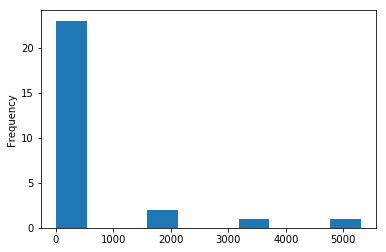

In [33]:
bioact_df_active.value.plot(kind='hist')

In [34]:
bioact_df_active[
    ['target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'molecule_chembl_id']
].groupby(
    ['target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description']
).count()

molecule_chembl_id
target_chembl_id target_pref_name                                      assay_chembl_id assay_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
CHEMBL1075104    Leucine-rich repeat serine/threonine-protein kinase 2 CHEMBL3367450   Inhibition of GST-tagged truncated LRRK2 (unknown origin) using fluorescein-labeled peptide LRRKtide as substrate by LANTHA screen assay in presence of 1 mM ATP                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          1                 
                                                                       CHEMBL3367451   Inhibition of phosphorylation at S935 residue of wild-type full-length LRRK2 kinase (unknown origin) expressed in HEK 293 cells after 90 mins by ELISA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1                 
CHEMBL1968       Epoxide hydrolase 1                                   CHEMBL3707738   Activity Assay: The invention also provide methods for assaying for epoxide hydrolase activity as diagnostic assay to identify individuals at increased risk for hypertension and/or those that would benefit from the therapeutic methods of the invention. Any of a number of standard assays for determining epoxide hydrolase activity can be used. For example, suitable assays are described in Gill, et al., Anal Biochem 131, 273-282 (1983); and Borhan, et al., Analytical Biochemistry 231, 188-200 (1995)). Suitable in vitro assays are described in Zeldin et al. J Biol. Chem. 268:6402-6407 (1993). Suitable in vivo assay

## Get ChEMBL target details: Protein target classification (PTC)

In order to access the protein target classification, we follow the instructions given here:

https://github.com/chembl/chembl_webservices_2/issues/95

In [35]:
target_chembl_ids = list(bioact_df_active.target_chembl_id.unique())
print(len(target_chembl_ids))
target_chembl_ids

17


['CHEMBL5393',
 'CHEMBL3708265',
 'CHEMBL2147',
 'CHEMBL3883328',
 'CHEMBL5407',
 'CHEMBL4523',
 'CHEMBL5443',
 'CHEMBL3038477',
 'CHEMBL3038469',
 'CHEMBL3038467',
 'CHEMBL301',
 'CHEMBL308',
 'CHEMBL1075104',
 'CHEMBL1968',
 'CHEMBL2842',
 'CHEMBL4630',
 'CHEMBL5578']

### Define request functions for `target`, `target_components` and `protein_class` ChEMBL endpoints

In [36]:
def extract_component_id_from_target(target_chembl_id):
    """
    Go to `target` endpoint and extract `component_id`
    """
    
    target_url = f'https://www.ebi.ac.uk/chembl/api/data/target/{target_chembl_id}.json'
    #print(target_url)
    
    response = requests.get(target_url)
    response.raise_for_status()
    result = response.json()

    component_ids = [i['component_id'] for i in result['target_components']]
    return component_ids


In [37]:
def extract_protein_classification_id_from_target_components(component_id):
    """
    Go to `target_components` endpoint and extract `protein_classification_id`
    """
    
    target_components_url = f'https://www.ebi.ac.uk/chembl/api/data/target_component/{component_id}.json'
    #print(target_components_url)

    response = requests.get(target_components_url)
    response.raise_for_status()  # this line checks for potential errors
    result = response.json()

    protein_classification_ids = [i['protein_classification_id'] for i in result['protein_classifications']]

    return protein_classification_ids

In [38]:
def get_protein_target_classification_from_protein_class(protein_classification_id):
    """
    Go to `protein_class` endpoint and extract protein target classification.
    """

    protein_class_url = f'https://www.ebi.ac.uk/chembl/api/data/protein_class/{protein_classification_id}.json'
    #print(protein_class_url)

    response = requests.get(protein_class_url)
    response.raise_for_status()  # this line checks for potential errors
    result = response.json()

    return pd.Series(result)

In [39]:
def get_protein_target_classifications(target_chembl_ids):
    """
    Get protein target classifications for a list of target ChEMBL IDs (in the form of a DataFrame).
    """

    results = []

    for target_chembl_id in target_chembl_ids:
        #print(target_chembl_id)

        # Go to `target` endpoint and extract `component_id`
        component_ids = extract_component_id_from_target(target_chembl_id)
        
        if len(component_ids) != 1:
            print(f'{target_chembl_id}: {len(component_ids)} component IDs for target ChEMBL ID.')

        for component_id in component_ids:
            #print(component_id)

            # Go to `target_components` endpoint and extract `protein_classification_id`
            protein_classification_ids = extract_protein_classification_id_from_target_components(component_id)

            if len(protein_classification_ids) != 1:
                print(f'{target_chembl_id}: {len(protein_classification_ids)} protein classification IDs for target ChEMBL ID.\n')    
            
            for protein_classification_id in protein_classification_ids:
                #print(protein_classification_id)

                # Go to `protein_class` endpoint and extract protein target classification.
                protein_target_classification = get_protein_target_classification_from_protein_class(protein_classification_id)

                # Add ID details
                protein_target_classification['target_chembl_id'] = target_chembl_id
                protein_target_classification['component_id'] = component_id
                protein_target_classification['protein_classification_id'] = protein_classification_id

                results.append(protein_target_classification)
                
    return pd.DataFrame(results)

### Get PTC for target ChEMBL IDs

Check for each query, how many protein target classification entries are available!

In [40]:
len(target_chembl_ids)

17

In [41]:
protein_target_classifications = get_protein_target_classifications(target_chembl_ids)

CHEMBL3883328: 2 component IDs for target ChEMBL ID.
CHEMBL3038477: 2 component IDs for target ChEMBL ID.
CHEMBL3038469: 2 component IDs for target ChEMBL ID.
CHEMBL3038467: 2 component IDs for target ChEMBL ID.


In [42]:
protein_target_classifications.shape

(21, 12)

In [43]:
len(protein_target_classifications.target_chembl_id.unique())

17

### Look at protein target classifications

In [44]:
protein_target_classifications

,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,target_chembl_id,component_id,protein_classification_id
0,Transporter,Primary active transporter,ATP-binding cassette,ABCG subfamily,None,None,None,None,750,CHEMBL5393,3688,750
1,Enzyme,None,None,None,None,None,None,None,1,CHEMBL3708265,10418,1
2,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,None,None,235,CHEMBL2147,489,235
3,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,CHEMBL3883328,699,129
4,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,CHEMBL3883328,2389,252
5,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,None,None,235,CHEMBL5407,3702,235
6,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,None,None,235,CHEMBL4523,2840,235
7,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CDC7 family,None,None,None,271,CHEMBL5443,5015,271
8,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,CHEMBL3038477,699,129
9,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,CHEMBL3038477,1946,252


### Per target ChEMBL ID, drop duplicated content (manually!)

Get indices that we want to drop - this is a manual step because we need to decide which entry per target ChEMBL ID we would like to keep/toss.

In [45]:
# Show target ChEMBL IDs with multiple PTCs
protein_target_classifications.groupby(
    by='target_chembl_id'
).apply(
    lambda x: x if (x.shape[0] > 1) else None
).dropna(
    how='all'
)

,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,target_chembl_id,component_id,protein_classification_id
3,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129.0,CHEMBL3883328,699.0,129.0
4,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252.0,CHEMBL3883328,2389.0,252.0
8,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129.0,CHEMBL3038477,699.0,129.0
9,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252.0,CHEMBL3038477,1946.0,252.0
10,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase CDK family,CMGC protein kinase CDC2 subfamily,None,None,323.0,CHEMBL3038469,36.0,323.0
11,Other cytosolic protein,None,None,None,None,None,None,None,8.0,CHEMBL3038469,918.0,8.0
12,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase CDK family,CMGC protein kinase CDC2 subfamily,None,None,323.0,CHEMBL3038467,7.0,323.0
13,Other cytosolic protein,None,None,None,None,None,None,None,8.0,CHEMBL3038467,918.0,8.0


In [46]:
# Manual step!!
drop_class_ix = [3, 8, 11, 13]

In [47]:
protein_target_classifications.shape

(21, 12)

In [48]:
protein_target_classifications.drop(drop_class_ix, inplace=True)

In [49]:
protein_target_classifications.shape

(17, 12)

### Show enzyme group distribution

In [50]:
len(protein_target_classifications.l2)

17

In [51]:
protein_target_classifications.groupby(by='l2').size()

l2
Kinase                        13
Primary active transporter    1 
Protease                      1 
dtype: int64

## Combine molecule, bioactivity, and target information

In [52]:
protein_target_classifications.shape

(17, 12)

In [53]:
bioact_df_active.shape

(27, 6)

In [54]:
molecules_targets_details = pd.merge(
    bioact_df_active, protein_target_classifications, on='target_chembl_id', how='left'
).sort_values(
    by='molecule_chembl_id'
)
molecules_targets_details.shape

(27, 17)

In [55]:
molecules_targets_details = molecules_targets_details[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'assay_chembl_id', 'assay_description', 'value']
]
molecules_targets_details.sort_values(by=['molecule_chembl_id', 'value'], inplace=True)

In [56]:
molecules_targets_details

,molecule_chembl_id,target_chembl_id,target_pref_name,l1,l2,l3,l4,l5,l6,assay_chembl_id,assay_description,value
0,CHEMBL1410991,CHEMBL5393,ATP-binding cassette sub-family G member 2,Transporter,Primary active transporter,ATP-binding cassette,ABCG subfamily,None,None,CHEMBL4015695,Inhibition of recombinant human GFP-fused ABCG2 expressed in MDCK2 cells assessed as reduction in Hoechst 33342 efflux preincubated for 30 mins followed by Hoechst 33342 addition measured immediately at 60 sec time interval for 120 mins by fluorescence assay,211.0
1,CHEMBL1709874,CHEMBL3708265,"7,8-dihydro-8-oxoguanine triphosphatase",Enzyme,None,None,None,None,None,CHEMBL3877226,Inhibition of DsRed-fused MTH1 (unknown origin) expressed in HEK293T cells using 8-oxo-dGTP as substrate,100.0
4,CHEMBL2030386,CHEMBL5407,Serine/threonine-protein kinase PIM3,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2038010,Inhibition of N-terminal His-tagged human PIM3 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,4.0
6,CHEMBL2030386,CHEMBL2147,Serine/threonine-protein kinase PIM1,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2038008,Inhibition of N-terminal His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,5.0
9,CHEMBL2030386,CHEMBL5443,Cell division cycle 7-related protein kinase,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CDC7 family,None,CHEMBL2034660,Inhibition of N-terminus Myc-tagged human CDC7 expressed in Escherichia coli by chemiluminescence assay in presence of ATP,5.5
2,CHEMBL2030386,CHEMBL2147,Serine/threonine-protein kinase PIM1,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2034662,Inhibition of N-terminus His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by chemiluminescence assay,13.0
5,CHEMBL2030386,CHEMBL4523,Serine/threonine-protein kinase PIM2,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2038009,Inhibition of N-terminal His-tagged human PIM2 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,68.0
8,CHEMBL2030386,CHEMBL3038477,Casein kinase II alpha/beta,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,CHEMBL2034661,Inhibition of human tertrameric CK2alphabeta holoenzyme using casein as substrate after 1 to 2 hrs by chemiluminescence assay in presence of 2 uM ATP,89.0
3,CHEMBL2030386,CHEMBL3883328,Casein kinase II alpha'/ beta,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,CHEMBL2038011,Inhibition of N-terminal MBP-tagged human alpha2beta2 CK2 expressed in Escherichia coli using casein as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,95.0
7,CHEMBL2030386,CHEMBL5443,Cell division cycle 7-related protein kinase,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CDC7 family,None,CHEMBL2034663,Inhibition of CDC7 in human MDA-MB-231T cells assessed as inhibition of MCM2 phosphorylation at Ser53 after 4 hrs,1805.0


In [57]:
filtering = add_filtering_step(filtering, molecules_targets_details, '(Sanity check: Still the same after activity-target merge?)')
filtering = add_filtering_step(filtering, molecules_targets_details[molecules_targets_details.l2 == 'Kinase'], 'Only kinases')
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69
1,Only human entries,24,33,46,48
2,"Only ""active"" entries",11,17,25,27
3,(Sanity check: Still the same after activity-target merge?),11,17,25,27
4,Only kinases,8,13,21,22


## Map kinases to KinMap

In [58]:
# Get KinMap relevant data
kinmap_data = molecules_targets_details[['molecule_chembl_id', 'target_pref_name', 'value']].copy()

### Add KinMap kinase names

In [59]:
# Manual step: Add KinMap kinase names to DataFrame
kinase_names = [
    None, None, 'PIM3', 'PIM1', 'CDC7', 'PIM1', 'PIM2', 'CK2a1', 'CK2a2', 'CDC7', 
    'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'LRRK2', 'LRRK2', 
    None, 'FRAP', 'CHK1', None, 'CHK1', None, 'CDC7'
]

kinmap_data['xName'] = kinase_names

In [60]:
kinmap_data

,molecule_chembl_id,target_pref_name,value,xName
0,CHEMBL1410991,ATP-binding cassette sub-family G member 2,211.0,None
1,CHEMBL1709874,"7,8-dihydro-8-oxoguanine triphosphatase",100.0,None
4,CHEMBL2030386,Serine/threonine-protein kinase PIM3,4.0,PIM3
6,CHEMBL2030386,Serine/threonine-protein kinase PIM1,5.0,PIM1
9,CHEMBL2030386,Cell division cycle 7-related protein kinase,5.5,CDC7
2,CHEMBL2030386,Serine/threonine-protein kinase PIM1,13.0,PIM1
5,CHEMBL2030386,Serine/threonine-protein kinase PIM2,68.0,PIM2
8,CHEMBL2030386,Casein kinase II alpha/beta,89.0,CK2a1
3,CHEMBL2030386,Casein kinase II alpha'/ beta,95.0,CK2a2
7,CHEMBL2030386,Cell division cycle 7-related protein kinase,1805.0,CDC7


In [61]:
# Drop molecules without kinase name
kinmap_data = kinmap_data[~kinmap_data.xName.isna()].copy()

In [62]:
# Drop target preference name (not needed any more)
kinmap_data.drop('target_pref_name', axis=1, inplace=True)
kinmap_data

,molecule_chembl_id,value,xName
4,CHEMBL2030386,4.0,PIM3
6,CHEMBL2030386,5.0,PIM1
9,CHEMBL2030386,5.5,CDC7
2,CHEMBL2030386,13.0,PIM1
5,CHEMBL2030386,68.0,PIM2
8,CHEMBL2030386,89.0,CK2a1
3,CHEMBL2030386,95.0,CK2a2
7,CHEMBL2030386,1805.0,CDC7
15,CHEMBL269827,2.3,CDK2
14,CHEMBL269827,2.3,CDK2


### Add colors per molecule

In [63]:
# Assign colors to each molecule

molecule_colors = {}
colors = 'red blue yellow green orange magenta cyan brown black darkgreen darkblue'.split()
molecules = molecules_targets_details.molecule_chembl_id.unique()

for molecule, color in zip(molecules, colors):
    molecule_colors[molecule] = color
    
print(molecule_colors)
    
kinmap_data['fill'] = kinmap_data.apply(lambda x: molecule_colors[x.molecule_chembl_id], axis=1)

{'CHEMBL1410991': 'red', 'CHEMBL1709874': 'blue', 'CHEMBL2030386': 'yellow', 'CHEMBL269827': 'green', 'CHEMBL311992': 'orange', 'CHEMBL3326132': 'magenta', 'CHEMBL3661365': 'cyan', 'CHEMBL4068426': 'brown', 'CHEMBL470288': 'black', 'CHEMBL520734': 'darkgreen', 'CHEMBL526133': 'darkblue'}


In [64]:
# Add other visualization parameters

kinmap_data['size'] = 20
kinmap_data['shape'] = 'circle'
kinmap_data['stroke'] = 'black'
kinmap_data['strokeWidth'] = 1.5

### Make stroke width relative to number of bioactivities per target

In [65]:
kinmap_data_n = kinmap_data.groupby(
    by=['molecule_chembl_id', 'xName', 'shape', 'fill', 'size', 'stroke', 'strokeWidth']
).count()
kinmap_data_n

value
molecule_chembl_id xName shape  fill      size stroke strokeWidth       
CHEMBL2030386      CDC7  circle yellow    20   black  1.5          2    
                   CK2a1 circle yellow    20   black  1.5          1    
                   CK2a2 circle yellow    20   black  1.5          1    
                   PIM1  circle yellow    20   black  1.5          2    
                   PIM2  circle yellow    20   black  1.5          1    
                   PIM3  circle yellow    20   black  1.5          1    
CHEMBL269827       CDK2  circle green     20   black  1.5          7    
CHEMBL311992       CDK2  circle orange    20   black  1.5          1    
CHEMBL3326132      LRRK2 circle magenta   20   black  1.5          2    
CHEMBL4068426      FRAP  circle brown     20   black  1.5          1    
CHEMBL470288       CHK1  circle black     20   black  1.5          1    
CHEMBL520734       CHK1  circle darkgreen 20   black  1.5          1    
CHEMBL526133       CDC7  circle darkblue  20   black  1.5          1

In [66]:
stroke_width = kinmap_data_n['value'].reset_index(drop=True) * 1.5
stroke_width

0     3.0 
1     1.5 
2     1.5 
3     3.0 
4     1.5 
5     1.5 
6     10.5
7     1.5 
8     3.0 
9     1.5 
10    1.5 
11    1.5 
12    1.5 
Name: value, dtype: float64

### Make size relative to mean bioactivity values

In [67]:
def get_size_by_bioactivity(bioactivity):
    
    if 0 < bioactivity <= 5:
        return 25
    elif 5 < bioactivity <=50:
        return 20
    elif 50 < bioactivity <= 500:
        return 15
    else:
        return 10

In [68]:
kinmap_data_mean = kinmap_data.groupby(
    by=['molecule_chembl_id', 'xName', 'shape', 'fill', 'size', 'stroke', 'strokeWidth']
).mean()
kinmap_data_mean

value
molecule_chembl_id xName shape  fill      size stroke strokeWidth         
CHEMBL2030386      CDC7  circle yellow    20   black  1.5          905.25 
                   CK2a1 circle yellow    20   black  1.5          89.00  
                   CK2a2 circle yellow    20   black  1.5          95.00  
                   PIM1  circle yellow    20   black  1.5          9.00   
                   PIM2  circle yellow    20   black  1.5          68.00  
                   PIM3  circle yellow    20   black  1.5          4.00   
CHEMBL269827       CDK2  circle green     20   black  1.5          5.60   
CHEMBL311992       CDK2  circle orange    20   black  1.5          12.00  
CHEMBL3326132      LRRK2 circle magenta   20   black  1.5          1067.00
CHEMBL4068426      FRAP  circle brown     20   black  1.5          415.00 
CHEMBL470288       CHK1  circle black     20   black  1.5          10.00  
CHEMBL520734       CHK1  circle darkgreen 20   black  1.5          6.00   
CHEMBL526133       CDC7  circle darkblue  20   black  1.5          10.00

In [69]:
size = kinmap_data_mean['value'].reset_index(drop=True).apply(lambda x: get_size_by_bioactivity(x))
size

0     10
1     15
2     15
3     20
4     15
5     25
6     20
7     20
8     10
9     15
10    20
11    20
12    20
Name: value, dtype: int64

In [70]:
kinmap_data_scaled = kinmap_data_n.reset_index(drop=False).drop('value', axis=1)
kinmap_data_scaled.size = size
kinmap_data_scaled.strokeWidth = stroke_width

In [71]:
kinmap_data_scaled

,molecule_chembl_id,xName,shape,fill,size,stroke,strokeWidth
0,CHEMBL2030386,CDC7,circle,yellow,10,black,3.0
1,CHEMBL2030386,CK2a1,circle,yellow,15,black,1.5
2,CHEMBL2030386,CK2a2,circle,yellow,15,black,1.5
3,CHEMBL2030386,PIM1,circle,yellow,20,black,3.0
4,CHEMBL2030386,PIM2,circle,yellow,15,black,1.5
5,CHEMBL2030386,PIM3,circle,yellow,25,black,1.5
6,CHEMBL269827,CDK2,circle,green,20,black,10.5
7,CHEMBL311992,CDK2,circle,orange,20,black,1.5
8,CHEMBL3326132,LRRK2,circle,magenta,10,black,3.0
9,CHEMBL4068426,FRAP,circle,brown,15,black,1.5


### Save to file for KinMap upload

In [72]:
kinmap_data_scaled.to_csv('chembl_molecule_details/chembl_molecule_details.csv')

In [73]:
for group_name, group in kinmap_data_scaled.groupby(by='molecule_chembl_id'):
    group.to_csv(f'chembl_molecule_details/chembl_molecule_details_{group_name}_n{group.shape[0]}.csv')

## Wrap-up

In [74]:
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69
1,Only human entries,24,33,46,48
2,"Only ""active"" entries",11,17,25,27
3,(Sanity check: Still the same after activity-target merge?),11,17,25,27
4,Only kinases,8,13,21,22


## Show molecules

In [105]:
details_selected = details[details.chembl_id.apply(lambda x: x in bioact_df_active.molecule_chembl_id.unique())]

In [142]:
bioact_df_active.groupby(by='')

,molecule_chembl_id,target_chembl_id,target_pref_name,assay_chembl_id,assay_description,value
66,CHEMBL1410991,CHEMBL5393,ATP-binding cassette sub-family G member 2,CHEMBL4015695,Inhibition of recombinant human GFP-fused ABCG2 expressed in MDCK2 cells assessed as reduction in Hoechst 33342 efflux preincubated for 30 mins followed by Hoechst 33342 addition measured immediately at 60 sec time interval for 120 mins by fluorescence assay,211.0
61,CHEMBL1709874,CHEMBL3708265,"7,8-dihydro-8-oxoguanine triphosphatase",CHEMBL3877226,Inhibition of DsRed-fused MTH1 (unknown origin) expressed in HEK293T cells using 8-oxo-dGTP as substrate,100.0
36,CHEMBL2030386,CHEMBL2147,Serine/threonine-protein kinase PIM1,CHEMBL2034662,Inhibition of N-terminus His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by chemiluminescence assay,13.0
41,CHEMBL2030386,CHEMBL3883328,Casein kinase II alpha'/ beta,CHEMBL2038011,Inhibition of N-terminal MBP-tagged human alpha2beta2 CK2 expressed in Escherichia coli using casein as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,95.0
40,CHEMBL2030386,CHEMBL5407,Serine/threonine-protein kinase PIM3,CHEMBL2038010,Inhibition of N-terminal His-tagged human PIM3 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,4.0
39,CHEMBL2030386,CHEMBL4523,Serine/threonine-protein kinase PIM2,CHEMBL2038009,Inhibition of N-terminal His-tagged human PIM2 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,68.0
38,CHEMBL2030386,CHEMBL2147,Serine/threonine-protein kinase PIM1,CHEMBL2038008,Inhibition of N-terminal His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,5.0
37,CHEMBL2030386,CHEMBL5443,Cell division cycle 7-related protein kinase,CHEMBL2034663,Inhibition of CDC7 in human MDA-MB-231T cells assessed as inhibition of MCM2 phosphorylation at Ser53 after 4 hrs,1805.0
35,CHEMBL2030386,CHEMBL3038477,Casein kinase II alpha/beta,CHEMBL2034661,Inhibition of human tertrameric CK2alphabeta holoenzyme using casein as substrate after 1 to 2 hrs by chemiluminescence assay in presence of 2 uM ATP,89.0
34,CHEMBL2030386,CHEMBL5443,Cell division cycle 7-related protein kinase,CHEMBL2034660,Inhibition of N-terminus Myc-tagged human CDC7 expressed in Escherichia coli by chemiluminescence assay in presence of ATP,5.5


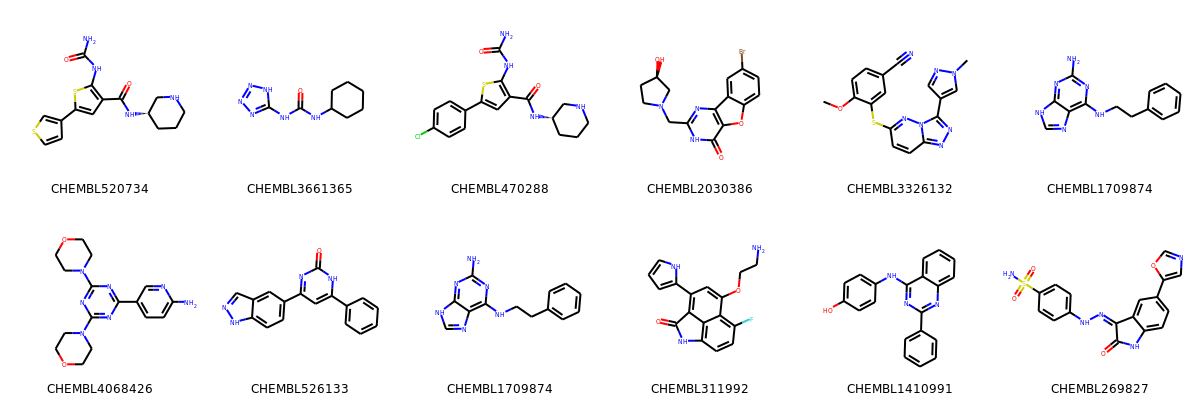

In [139]:
mols = []

for smiles in details_selected.smiles:
    mols.append(Chem.MolFromSmiles(smiles))
    
Draw.MolsToGridImage(mols, molsPerRow=6, legends=list(details_selected.chembl_id))

## Get all ATC classified molecules

In [75]:
# Check if first_approval field is not empty
details[details.first_approval == details.first_approval]

,atc_classification,chembl_id,first_approval,inchi,smiles


In [76]:
# Check if atc classified field is not empty
details[details.atc_classification.str.len() != 0]

,atc_classification,chembl_id,first_approval,inchi,smiles


## Get all approved drugs

In [77]:
approved_drugs = compound.filter(molecule_chembl_id__in = list(details.chembl_id), max_phase=4)

In [78]:
len(approved_drugs)

1

In [79]:
approved_mol = approved_drugs[0]

In [80]:
chembl_id = approved_mol['molecule_chembl_id']
chembl_id

'CHEMBL1909282'

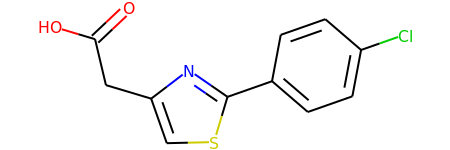

In [135]:
Chem.MolFromSmiles(
    details[details.chembl_id == chembl_id].smiles.values[0]
)

In [81]:
activities_approved_drugs = activity.filter(
    molecule_chembl_id = chembl_id,
    type = 'IC50',
    assay_type = 'B'
).only(
    'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
    'molecule_chembl_id', 'type', 'units', 'relation', 'value', \
    'target_chembl_id', 'target_organism'
)

In [82]:
activities_approved_drugs = pd.DataFrame.from_records(list(activities_approved_drugs))
activities_approved_drugs

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,15460367,CHEMBL3540574,Inhibition of Sprague-Dawley rat Bsep expressed in plasma membrane vesicles of Sf21 cells assessed as inhibition of ATP-dependent [3H]taurocholate uptake,B,CHEMBL1909282,>,CHEMBL2073674,Rattus norvegicus,IC50,uM,1000
1,15460435,CHEMBL3540573,Inhibition of human BSEP expressed in plasma membrane vesicles of Sf21 cells assessed as inhibition of ATP-dependent [3H]taurocholate uptake,B,CHEMBL1909282,>,CHEMBL6020,Homo sapiens,IC50,uM,1000


In [83]:
get_protein_target_classifications(activities_approved_drugs.target_chembl_id)

,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,target_chembl_id,component_id,protein_classification_id
0,Transporter,Primary active transporter,ATP-binding cassette,ABCB subfamily,None,None,None,None,1132,CHEMBL2073674,5895,1132
1,Transporter,Primary active transporter,ATP-binding cassette,ABCB subfamily,None,None,None,None,1132,CHEMBL6020,4541,1132
